<a href="https://colab.research.google.com/github/profsuccodifrutta/ai_act_RAG_navigator/blob/main/ai_act_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREATION OF ENVIORMENT**

In [2]:
# install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
import sys
import os
from google.colab import userdata
sys.path.append("/root/.cargo/bin")

# configuratrion github with secrets
GIT_USER = "profsuccodifrutta"
GIT_REPO = "ai_act_RAG_navigator"

try:
    # Assicurati che nell'icona della chiave il nome sia github_token
    GIT_TOKEN = userdata.get('github_token')
except Exception:
    print("ERRORE: Segreto 'github_token' non trovato. Controlla l'icona della chiave a sinistra.")
    sys.exit(1)

# clone repo
if not os.path.exists(GIT_REPO):
    !git clone https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git
else:
    print(f"folder {GIT_REPO} already exists.")

# project repo
%cd {GIT_REPO}

# Fix per il remote (necessario per il push)
!git remote set-url origin https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git

# initialization uv enviorment
if not os.path.exists("pyproject.toml"):
    !uv init
else:
    print("uv already initialized.")

# add libraries
!uv add langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv

# install on colab
!uv pip install --system langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv

print("\nEnviorment configuration completed")

downloading uv 0.10.3 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
folder ai_act_RAG_navigator already exists.
/content/ai_act_RAG_navigator
uv already initialized.
Resolved 99 packages in 6ms
Audited 97 packages in 280ms
Using Python 3.12.12 environment at: /usr
Audited 7 packages in 535ms

Enviorment configuration completed


In [3]:
# configuration
!git config --global user.email "matteo@drezzo.ch"
!git config --global user.name "profsuccodifrutta"
!git branch -M main

**PRE-PROCESSING**

In [4]:
from google.colab import drive
import os
import requests
import shutil
import fitz  # PyMuPDF
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc

creates a local data/ directory within the repository, and loads the official 144-page EU AI Act PDF. It also prepares a dedicated folder on Drive to store the future FAISS vector index

In [5]:
drive.mount('/content/drive')

# local env set up
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Folder '{data_dir}' created.")

# path configuration
drive_pdf_path = "/content/drive/MyDrive/compliance_and_regulation_rag/regulation_pdfs/ai_act_2024.pdf"

local_pdf_path = os.path.join(data_dir, "eu_ai_act.pdf") # local destination

# Copy file from Drive to Local Data folder
if os.path.exists(drive_pdf_path):
    shutil.copy(drive_pdf_path, local_pdf_path)
    print(f"File copied from Drive to: {local_pdf_path} ({os.path.getsize(local_pdf_path)} bytes)")
else:
    print(f"Error: File NOT found on Drive at {drive_pdf_path}")

# persistence folder for FAISS index
drive_persistence_path = "/content/drive/MyDrive/compliance_and_regulation_rag/ai_act_rag_index"
if not os.path.exists(drive_persistence_path):
    os.makedirs(drive_persistence_path)
    print("Folder for index persistence ready on Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied from Drive to: data/eu_ai_act.pdf (2583319 bytes)


extract_by_page_range: This function acts as a smart filter. It reads the PDF page-by-page and immediately assigns a "Legal Category" (Recital, Article, or Annex) based on the page number. It also scrubs away "typographic noise" like page numbers and ELI links to ensure the text is clean before it hits the processor.

build_legal_structure: This is the logical architect. Instead of using a one-size-fits-all rule, it applies different "cutting logic" to each category. It splits Recitals by their parenthetical numbers—(1), (2)—and Articles by the keyword Article X. This transforms a flat text file into a structured database of specific legal points.

In [6]:
def extract_by_page_range(path):
    doc = fitz.open(path)
    page_data = []
    # Pattern per eliminare il rumore che disturba la RAM e la Regex
    noise_pattern = re.compile(r"(\d+/144|ELI: http://data\.europa\.eu/eli/reg/.+|OJ L, 12\.7\.2024|EN)")

    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text")
        # cleaning
        clean_text = text.replace("-\n", "")
        lines = [noise_pattern.sub("", l).strip() for l in clean_text.split("\n")]
        final_page_text = " ".join([l for l in lines if l and not l.isdigit()])


        p_idx = page_num + 1
        if p_idx < 44:
            cat = "RECITAL"
        elif 44 <= p_idx <= 123:
            cat = "ARTICLE"
        else:
            cat = "ANNEX"

        page_data.append({"category": cat, "text": final_page_text})

    doc.close()
    return pd.DataFrame(page_data)

df_raw_pages = extract_by_page_range("data/eu_ai_act.pdf")
print("extraction completed.")

✅ Estrazione pagine completata.


In [7]:
def build_legal_structure(df):
    units = []

    for cat in ["RECITAL", "ARTICLE", "ANNEX"]:
        full_cat_text = " ".join(df[df['category'] == cat]['text'].tolist())

        if cat == "ARTICLE":
            content = re.split(r"(?i)Article\s+\d+", full_cat_text)
            titles = re.findall(r"(?i)Article\s+\d+", full_cat_text)
            for i in range(len(titles)):
                units.append({"id": titles[i].upper(), "text": content[i+1].strip()})

        elif cat == "RECITAL":
            content = re.split(r"\(\d+\)", full_cat_text)
            for i, text in enumerate(content[1:], 1):
                units.append({"id": f"RECITAL {i}", "text": text.strip()})

        else: # ANNEX
            content = re.split(r"(?i)ANNEX\s+[I|V|X]+", full_cat_text)
            titles = re.findall(r"(?i)ANNEX\s+[I|V|X]+", full_cat_text)
            for i in range(len(titles)):
                units.append({"id": titles[i].upper(), "text": content[i+1].strip()})

    return pd.DataFrame(units)

df_units = build_legal_structure(df_raw_pages)
df_units['len'] = df_units['text'].str.len()

print(f"UUnits created: {len(df_units)}")
print(f"Max lenght: {df_units['len'].max()}")

UUnits created: 814
Max lenght: 7340


**CHUNK ANALYSIS**

An embedding vector represents the "average" meaning of a text. If a chunk is too long and covers five different legal requirements, the vector becomes vague, making it harder for the system to find that specific information during a search. Even if an LLM can read a huge chunk, providing too much irrelevant text alongside the answer creates "noise." This increases the risk of the model hallucinating or missing the specific detail you're looking for.

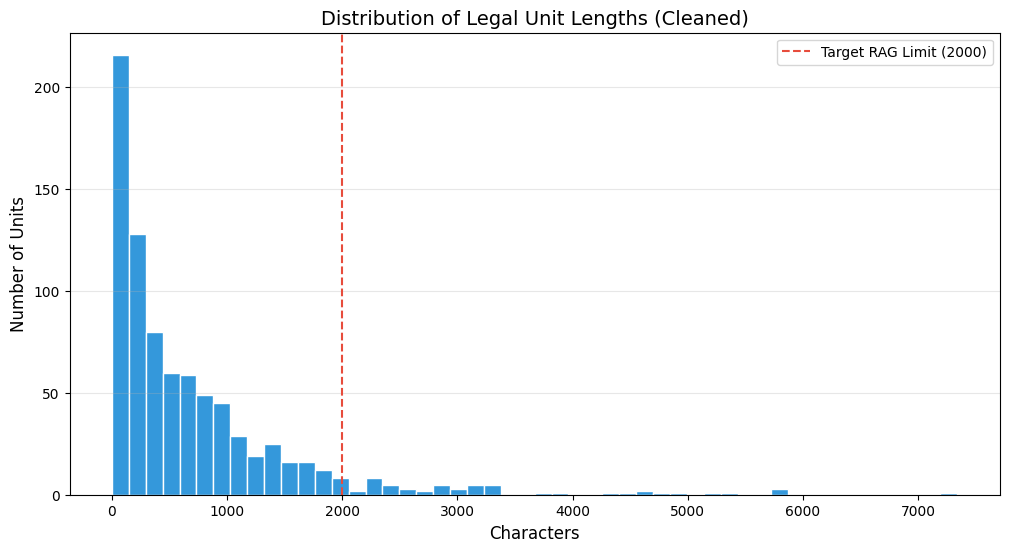

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(df_units['len'], bins=50, color='#3498db', edgecolor='white')
plt.axvline(2000, color='#e74c3c', linestyle='--', label='Target RAG Limit (2000)')
plt.title('Distribution of Legal Unit Lengths (Cleaned)', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Number of Units', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

**PUSH**

In [9]:
# for pushing
!git add .
!git commit -m "env created"
!git push -u origin main

[main 53f0155] env created
 2 files changed, 79937 insertions(+)
 create mode 100644 data/eu_ai_act.pdf
 create mode 100644 uv.lock
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 1.93 MiB | 7.16 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/profsuccodifrutta/ai_act_RAG_navigator.git
   e9eb429..53f0155  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.
